## Stable Diffusion Hacking 2 [Roll in DDIM sampler into the loop]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
# from diffusers import StableDiffusion3Pipeline
from diffusers import StableDiffusionPipeline
from diffusers import EulerDiscreteScheduler, EulerAncestralDiscreteScheduler, DPMSolverMultistepScheduler, LMSDiscreteScheduler
from diffusers import DDPMScheduler, DDIMScheduler
from diffusers.utils.torch_utils import randn_tensor

In [2]:
# model_id = "stabilityai/stable-diffusion-2"
model_id = "stabilityai/stable-diffusion-2-1"

# Use the Euler scheduler here instead
# scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler") #Woah so different!
# scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler") 
# scheduler = LMSDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler") 
# scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler") 
scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler") 
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
# StableDiffusionPipeline.from_pretrained?

In [4]:
# prompt = "a photo of an astronaut riding a horse on mars"
# prompt="A lone tree standing in the middle of a desert, under the harsh light of midday, casting a long shadow on the sand."
# prompt="The image depicts a humorous and surreal scene on a highway. An elderlywoman is riding a classic bicycle, speeding down the road at an astonishing pace. Her expression is one of determination, mixed with a hint of joy, while her scarf flutters wildly in the wind, emphasizing her incredible speed. Next to her, a sleek, modern sports car is visibly being overtaken. The driver, wide-eyed and astonished, glances at the speeding grandmother in disbelief. The highway scenery is blurred with motion streaks and light trails, enhancing the sense of extreme velocity. Dust and wind effects swirl around the bicycle wheels, creating an impression of a high-speed race. The sky above is bright blue with a few clouds, and modern road signs add to the dynamic urban setting.extrem funny"
# prompt="black and white photography, fashion editorial, a silhouette of woman with abstract hair in black and white, art concept, highres, realistic photo, professional photography, cinematic angle, dynamic light back shining,"
# prompt="fashion editorial, highly detailed photo, fashion photography, old paper close-up black haired girl with closed eyes in depression and anxiety, portrait, beauty, minimalist, decorative full flowing intricate fine detail, highres, realistic photo, professional photography, cinematic angle, dynamic light back shining,"
# image = pipe(prompt, guidance=5.0).images[0]

In [5]:
# image

In [6]:
# pipe.scheduler.compatibles

- Ok, let me see if I can take apart this `EulerDiscreteScheduler`
- Hmm actually I think i should take apart pipe first

In [7]:
# pipe.scheduler

In [8]:
prompt="A lone tree standing in the middle of a desert, under the harsh light of midday, casting a long shadow on the sand."
height = None
width = None
num_inference_steps = 50
timesteps =  None
sigmas = None
guidance_scale = 7.5
negative_prompt = None
num_images_per_prompt= 1
eta = 0.0
generator = None
latents = None
prompt_embeds = None
negative_prompt_embeds = None
ip_adapter_image =None
ip_adapter_image_embeds= None
output_type= "pil"
return_dict = True
cross_attention_kwargs = None
guidance_rescale = 0.0
clip_skip = None
callback_on_step_end = None
callback_on_step_end_tensor_inputs = ["latents"]

In [9]:
#Actually let's try fixing the seed. 
# generator = torch.Generator(device="cuda").manual_seed(8)
generator = torch.Generator(device="cuda").manual_seed(11)

In [10]:
if not height or not width:
    height = (
        pipe.unet.config.sample_size
        if pipe._is_unet_config_sample_size_int
        else pipe.unet.config.sample_size[0]
    )
    width = (
        pipe.unet.config.sample_size
        if pipe._is_unet_config_sample_size_int
        else pipe.unet.config.sample_size[1]
    )
    height, width = height * pipe.vae_scale_factor, width * pipe.vae_scale_factor

In [11]:
pipe._guidance_scale = guidance_scale
pipe._guidance_rescale = guidance_rescale
pipe._clip_skip = clip_skip
pipe._cross_attention_kwargs = cross_attention_kwargs
pipe._interrupt = False

In [12]:
# 2. Define call parameters
if prompt is not None and isinstance(prompt, str):
    batch_size = 1
elif prompt is not None and isinstance(prompt, list):
    batch_size = len(prompt)
else:
    batch_size = prompt_embeds.shape[0]

device = pipe._execution_device

In [13]:
batch_size

1

In [14]:
# 3. Encode input prompt
lora_scale = (
    pipe.cross_attention_kwargs.get("scale", None) if pipe.cross_attention_kwargs is not None else None
)

prompt_embeds, negative_prompt_embeds = pipe.encode_prompt(
    prompt,
    device,
    num_images_per_prompt,
    pipe.do_classifier_free_guidance,
    negative_prompt,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_prompt_embeds,
    lora_scale=lora_scale,
    clip_skip=pipe.clip_skip,
)

In [15]:
# For classifier free guidance, we need to do two forward passes.
# Here we concatenate the unconditional and text embeddings into a single batch
# to avoid doing two forward passes
if pipe.do_classifier_free_guidance:
    prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

if ip_adapter_image is not None or ip_adapter_image_embeds is not None:
    image_embeds = self.prepare_ip_adapter_image_embeds(
        ip_adapter_image,
        ip_adapter_image_embeds,
        device,
        batch_size * num_images_per_prompt,
        pipe.do_classifier_free_guidance,
    )

In [16]:
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion import retrieve_timesteps

In [17]:
# 4. Prepare timesteps
timesteps, num_inference_steps = retrieve_timesteps(
    pipe.scheduler, num_inference_steps, device, timesteps, sigmas
)


In [18]:
timesteps

tensor([981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721,
        701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441,
        421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161,
        141, 121, 101,  81,  61,  41,  21,   1], device='cuda:0')

In [19]:
# num_inference_steps

In [20]:
# 5. Prepare latent variables
num_channels_latents = pipe.unet.config.in_channels
latents = pipe.prepare_latents(
    batch_size * num_images_per_prompt,
    num_channels_latents,
    height,
    width,
    prompt_embeds.dtype,
    device,
    generator,
    latents,
)

In [21]:
latents.shape

torch.Size([1, 4, 96, 96])

In [22]:
# 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
extra_step_kwargs = pipe.prepare_extra_step_kwargs(generator, eta)

# 6.1 Add image embeds for IP-Adapter
added_cond_kwargs = (
    {"image_embeds": image_embeds}
    if (ip_adapter_image is not None or ip_adapter_image_embeds is not None)
    else None
)

# 6.2 Optionally get Guidance Scale Embedding
timestep_cond = None
if pipe.unet.config.time_cond_proj_dim is not None:
    guidance_scale_tensor = torch.tensor(self.guidance_scale - 1).repeat(batch_size * num_images_per_prompt)
    timestep_cond = self.get_guidance_scale_embedding(
        guidance_scale_tensor, embedding_dim=self.unet.config.time_cond_proj_dim
    ).to(device=device, dtype=latents.dtype)

- Ok, now can i creak into `pipe.scheduler.step`?

In [23]:
# pipe.scheduler.config.prediction_type = "v_prediction" #Try simpler prediction type, v_prediction is the only one giving good results right now. 

In [24]:
res={'latent_model_input':[], 'noise_pred_uncond':[], 'noise_pred_text':[], 'noise_pred':[], 'latents':[]}

# 7. Denoising loop
with torch.no_grad():
    num_warmup_steps = len(timesteps) - num_inference_steps * pipe.scheduler.order
    pipe._num_timesteps = len(timesteps)
    with pipe.progress_bar(total=num_inference_steps) as progress_bar:
        for i, t in enumerate(timesteps):
            # if pipe.interrupt:
            #     continue

            res['latent_model_input'].append(latents.detach().cpu().numpy())
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if pipe.do_classifier_free_guidance else latents
            latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
    
            # predict the noise residual
            noise_pred = pipe.unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                timestep_cond=timestep_cond,
                cross_attention_kwargs=pipe.cross_attention_kwargs,
                added_cond_kwargs=added_cond_kwargs,
                return_dict=False,
            )[0]
    
            # perform guidance
            if pipe.do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + pipe.guidance_scale * (noise_pred_text - noise_pred_uncond)

            res['noise_pred_uncond'].append(noise_pred_uncond.detach().cpu().numpy())
            res['noise_pred_text'].append(noise_pred_text.detach().cpu().numpy())
            res['noise_pred'].append(noise_pred.detach().cpu().numpy())

            if pipe.do_classifier_free_guidance and pipe.guidance_rescale > 0.0: #pipe.guidance_rescale=0.0
                # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=pipe.guidance_rescale)
    
            # compute the previous noisy sample x_t -> x_t-1
            # latents = pipe.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

            ## --- Scheduler override --- ##
            ## DDIM Scheduler
            # self,
            model_output = noise_pred
            timestep = t
            sample = latents
            eta = 0.0
            use_clipped_model_output = False
            generator=generator
            variance_noise =  None
            return_dict = False
            
            # 1. get previous step value (=t-1)
            prev_timestep = timestep - pipe.scheduler.config.num_train_timesteps // pipe.scheduler.num_inference_steps
            
            
            # 2. compute alphas, betas
            alpha_prod_t = pipe.scheduler.alphas_cumprod[timestep]
            alpha_prod_t_prev = pipe.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else pipe.scheduler.final_alpha_cumprod
            
            beta_prod_t = 1 - alpha_prod_t
            
            # 3. compute predicted original sample from predicted noise also called
            # "predicted x_0" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
            if  pipe.scheduler.config.prediction_type == "epsilon":
                pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)
                pred_epsilon = model_output
            elif  pipe.scheduler.config.prediction_type == "sample":
                pred_original_sample = model_output
                pred_epsilon = (sample - alpha_prod_t ** (0.5) * pred_original_sample) / beta_prod_t ** (0.5)
            elif  pipe.scheduler.config.prediction_type == "v_prediction":
                pred_original_sample = (alpha_prod_t**0.5) * sample - (beta_prod_t**0.5) * model_output
                pred_epsilon = (alpha_prod_t**0.5) * model_output + (beta_prod_t**0.5) * sample
            else:
                raise ValueError(
                    f"prediction_type given as {self.config.prediction_type} must be one of `epsilon`, `sample`, or"
                    " `v_prediction`")
            
            # 4. Clip or threshold "predicted x_0"
            if pipe.scheduler.config.thresholding: #False
                pred_original_sample = self._threshold_sample(pred_original_sample)
            elif pipe.scheduler.config.clip_sample: #False
                pred_original_sample = pred_original_sample.clamp(
                    -self.config.clip_sample_range, self.config.clip_sample_range
                )
            
            # 5. compute variance: "sigma_t(η)" -> see formula (16)
            # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
            variance = pipe.scheduler._get_variance(timestep, prev_timestep)
            std_dev_t = eta * variance ** (0.5)
            
            if use_clipped_model_output: #False
                # the pred_epsilon is always re-derived from the clipped x_0 in Glide
                pred_epsilon = (sample - alpha_prod_t ** (0.5) * pred_original_sample) / beta_prod_t ** (0.5)

            #SW - this might be a cleaner way to perturb things
            # alpha_prod_t_prev=1.01*alpha_prod_t_prev
            
            # 6. compute "direction pointing to x_t" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
            pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2) ** (0.5) * pred_epsilon

            
            # 7. compute x_t without "random noise" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
            prev_sample = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction

            ## 7 variant - SW Pertebation
            # prev_sample = 1.01*alpha_prod_t_prev ** (0.5) * pred_original_sample + 0.99*pred_sample_direction
            
            
            if eta > 0:
                if variance_noise is not None and generator is not None:
                    raise ValueError(
                        "Cannot pass both generator and variance_noise. Please make sure that either `generator` or"
                        " `variance_noise` stays `None`."
                    )
            
                if variance_noise is None:
                    variance_noise = randn_tensor(
                        model_output.shape, generator=generator, device=model_output.device, dtype=model_output.dtype
                    )
                variance = std_dev_t * variance_noise
            
                prev_sample = prev_sample + variance
    
            latents = prev_sample
            ### --- end scheduler hacking ---- ###
            
            res['latents'].append(latents.detach().cpu().numpy())

            # call the callback, if provided
            if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % pipe.scheduler.order == 0):
                progress_bar.update()

            # if i == 35: break #Stop early to dig into scheduler

  0%|          | 0/50 [00:00<?, ?it/s]

In [25]:
if not output_type == "latent":
    image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False, generator=generator)[
        0
    ]
    image, has_nsfw_concept = pipe.run_safety_checker(image, device, prompt_embeds.dtype)
else:
    image = latents
    has_nsfw_concept = None

if has_nsfw_concept is None:
    do_denormalize = [True] * image.shape[0]
else:
    do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]
image = pipe.image_processor.postprocess(image.detach(), output_type=output_type, do_denormalize=do_denormalize)


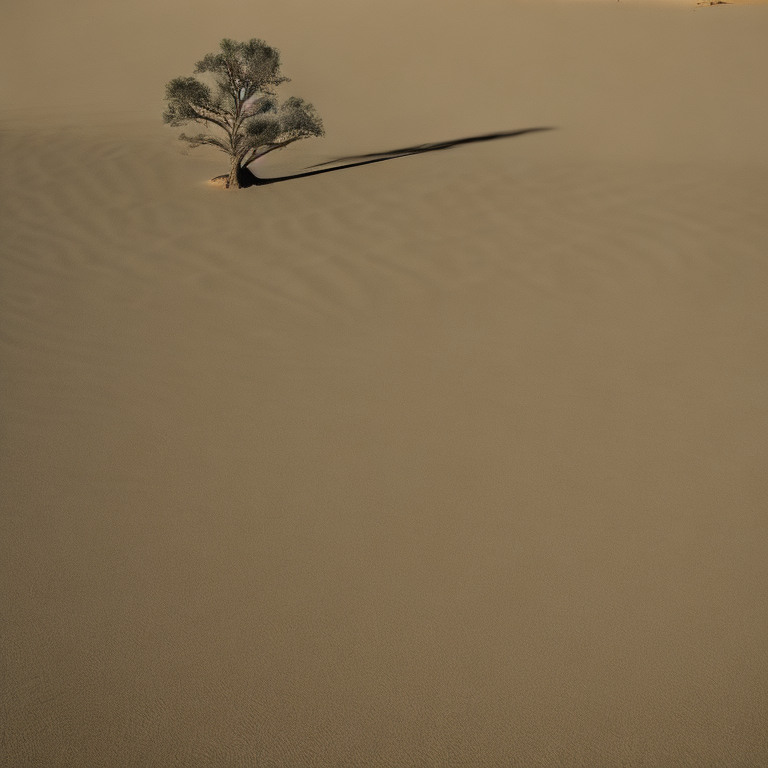

In [26]:
image[0]

- Woah holy shit for DDPM sampling, adding the noise matter a lot!
- That sampling method seems to matter a lot too - woah
- Ok I think i want to try one more little thing here - just like my own naive approach. 

In [27]:
assert False

AssertionError: 

In [ ]:
pipe.scheduler.config.thresholding

In [ ]:
pipe.scheduler.config.clip_sample

In [ ]:
## DDIM Scheduler
# self,
model_output = noise_pred
timestep = t
sample = latents
eta = 0.0
use_clipped_model_output = False
generator=generator
variance_noise =  None
return_dict = False

# 1. get previous step value (=t-1)
prev_timestep = timestep - pipe.scheduler.config.num_train_timesteps // pipe.scheduler.num_inference_steps


# 2. compute alphas, betas
alpha_prod_t = pipe.scheduler.alphas_cumprod[timestep]
alpha_prod_t_prev = pipe.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else pipe.scheduler.final_alpha_cumprod

beta_prod_t = 1 - alpha_prod_t

# 3. compute predicted original sample from predicted noise also called
# "predicted x_0" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
if  pipe.scheduler.config.prediction_type == "epsilon":
    pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)
    pred_epsilon = model_output
elif  pipe.scheduler.config.prediction_type == "sample":
    pred_original_sample = model_output
    pred_epsilon = (sample - alpha_prod_t ** (0.5) * pred_original_sample) / beta_prod_t ** (0.5)
elif  pipe.scheduler.config.prediction_type == "v_prediction":
    pred_original_sample = (alpha_prod_t**0.5) * sample - (beta_prod_t**0.5) * model_output
    pred_epsilon = (alpha_prod_t**0.5) * model_output + (beta_prod_t**0.5) * sample
else:
    raise ValueError(
        f"prediction_type given as {self.config.prediction_type} must be one of `epsilon`, `sample`, or"
        " `v_prediction`")

# 4. Clip or threshold "predicted x_0"
if pipe.scheduler.config.thresholding:
    pred_original_sample = self._threshold_sample(pred_original_sample)
elif pipe.scheduler.config.clip_sample:
    pred_original_sample = pred_original_sample.clamp(
        -self.config.clip_sample_range, self.config.clip_sample_range
    )


# 5. compute variance: "sigma_t(η)" -> see formula (16)
# σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
variance = pipe.scheduler._get_variance(timestep, prev_timestep)
std_dev_t = eta * variance ** (0.5)

if use_clipped_model_output: #False
    # the pred_epsilon is always re-derived from the clipped x_0 in Glide
    pred_epsilon = (sample - alpha_prod_t ** (0.5) * pred_original_sample) / beta_prod_t ** (0.5)

# 6. compute "direction pointing to x_t" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2) ** (0.5) * pred_epsilon

# 7. compute x_t without "random noise" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
prev_sample = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction

if eta > 0:
    if variance_noise is not None and generator is not None:
        raise ValueError(
            "Cannot pass both generator and variance_noise. Please make sure that either `generator` or"
            " `variance_noise` stays `None`."
        )

    if variance_noise is None:
        variance_noise = randn_tensor(
            model_output.shape, generator=generator, device=model_output.device, dtype=model_output.dtype
        )
    variance = std_dev_t * variance_noise

    prev_sample = prev_sample + variance

In [ ]:
eta

In [ ]:
pipe.scheduler.config.prediction_type

In [ ]:
use_clipped_model_output

In [ ]:
timesteps

In [ ]:
extra_step_kwargs

In [ ]:
pipe.scheduler.config

In [ ]:
pipe.scheduler

---

In [ ]:
## --- DDPM Scheduler --- ##
# def step(
# self,
model_output = noise_pred
timestep = t
sample = latents
generator = generator
return_dict = False

In [ ]:
t = timestep

prev_t = pipe.scheduler.previous_timestep(t)

if model_output.shape[1] == sample.shape[1] * 2 and pipe.scheduler.variance_type in ["learned", "learned_range"]:
    model_output, predicted_variance = torch.split(model_output, sample.shape[1], dim=1)
else:
    predicted_variance = None

In [ ]:
model_output.shape

In [ ]:
# 1. compute alphas, betas
alpha_prod_t = pipe.scheduler.alphas_cumprod[t]
alpha_prod_t_prev = pipe.scheduler.alphas_cumprod[prev_t] if prev_t >= 0 else pipe.scheduler.one
beta_prod_t = 1 - alpha_prod_t
beta_prod_t_prev = 1 - alpha_prod_t_prev
current_alpha_t = alpha_prod_t / alpha_prod_t_prev
current_beta_t = 1 - current_alpha_t

In [ ]:
# 2. compute predicted original sample from predicted noise also called
# "predicted x_0" of formula (15) from https://arxiv.org/pdf/2006.11239.pdf
if pipe.scheduler.config.prediction_type == "epsilon":
    pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)
elif pipe.scheduler.config.prediction_type == "sample":
    pred_original_sample = model_output
elif pipe.scheduler.config.prediction_type == "v_prediction":
    pred_original_sample = (alpha_prod_t**0.5) * sample - (beta_prod_t**0.5) * model_output
else:
    raise ValueError(
        f"prediction_type given as {self.config.prediction_type} must be one of `epsilon`, `sample` or"
        " `v_prediction`  for the DDPMScheduler."
    )

In [ ]:
pipe.scheduler.config.prediction_type

In [ ]:
pred_original_sample.shape

In [ ]:
# 3. Clip or threshold "predicted x_0"
if pipe.scheduler.config.thresholding:
    pred_original_sample = self._threshold_sample(pred_original_sample)
elif pipe.scheduler.config.clip_sample:
    pred_original_sample = pred_original_sample.clamp(
        -self.config.clip_sample_range, self.config.clip_sample_range
    )

In [ ]:
pipe.scheduler.config.clip_sample

In [ ]:
pipe.scheduler.config.thresholding

In [ ]:
# 4. Compute coefficients for pred_original_sample x_0 and current sample x_t
# See formula (7) from https://arxiv.org/pdf/2006.11239.pdf
pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * current_beta_t) / beta_prod_t
current_sample_coeff = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t

In [ ]:
# 5. Compute predicted previous sample µ_t
# See formula (7) from https://arxiv.org/pdf/2006.11239.pdf
pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * sample


In [ ]:
current_sample_coeff, pred_original_sample_coeff

In [ ]:
# 6. Add noise
variance = 0
if t > 0:
    device = model_output.device
    variance_noise = randn_tensor(
        model_output.shape, generator=generator, device=device, dtype=model_output.dtype
    )
    if pipe.scheduler.variance_type == "fixed_small_log":
        variance = pipe.scheduler._get_variance(t, predicted_variance=predicted_variance) * variance_noise
    elif pipe.scheduler.variance_type == "learned_range":
        variance = pipe.scheduler._get_variance(t, predicted_variance=predicted_variance)
        variance = torch.exp(0.5 * variance) * variance_noise
    else:
        variance = (pipe.scheduler._get_variance(t, predicted_variance=predicted_variance) ** 0.5) * variance_noise

pred_prev_sample = pred_prev_sample + variance

In [ ]:
variance.shape

In [ ]:
pipe.scheduler._get_variance(t, predicted_variance=predicted_variance)

In [ ]:
pipe.scheduler

In [ ]:
# def step( ### --- Eueler scheduler ---- ###
# self,
model_output = noise_pred
timestep = t
sample = latents
s_churn = 0.0
s_tmin = 0.0
s_tmax = float("inf")
s_noise = 1.0
generator = generator
return_dict = False

In [ ]:
if pipe.scheduler.step_index is None:
    pipe.scheduler._init_step_index(timestep)

# Upcast to avoid precision issues when computing prev_sample
sample = sample.to(torch.float32)
sigma = pipe.scheduler.sigmas[pipe.scheduler.step_index]
gamma = min(s_churn / (len(pipe.scheduler.sigmas) - 1), 2**0.5 - 1) if s_tmin <= sigma <= s_tmax else 0.0
sigma_hat = sigma * (gamma + 1)


In [ ]:
sigma

In [ ]:
# 1. compute predicted original sample (x_0) from sigma-scaled predicted noise
# NOTE: "original_sample" should not be an expected prediction_type but is left in for
# backwards compatibility
if pipe.scheduler.config.prediction_type == "original_sample" or pipe.scheduler.config.prediction_type == "sample":
    pred_original_sample = model_output
elif pipe.scheduler.config.prediction_type == "epsilon":
    pred_original_sample = sample - sigma_hat * model_output
elif pipe.scheduler.config.prediction_type == "v_prediction":
    # denoised = model_output * c_out + input * c_skip
    pred_original_sample = model_output * (-sigma / (sigma**2 + 1) ** 0.5) + (sample / (sigma**2 + 1))
else:
    raise ValueError(
        f"prediction_type given as {self.config.prediction_type} must be one of `epsilon`, or `v_prediction`"
    )

- So, as configured here, at the 35th step we're doing this:

```
pred_original_sample = -0.5925*model_output+1.5409*latents
```
- essentially always subtracking some model output from some latents in different proportions
- If we were in "eplison" mode, we would be doing the same thing, just a fixed ratio.
- In original_sample or sample mode, then `pred_original_sample = model_output` ?? No latents at all? There must be more to come?
- I see there's an `add_noise` mtehod in the Secheduler class, but it's never called?

In [ ]:
# 2. Convert to an ODE derivative
derivative = (sample - pred_original_sample) / sigma_hat

dt = pipe.scheduler.sigmas[pipe.scheduler.step_index + 1] - sigma_hat

prev_sample = sample + derivative * dt

# Cast sample back to model compatible dtype
prev_sample = prev_sample.to(model_output.dtype)

# upon completion increase step index by one
pipe.scheduler._step_index += 1

In [ ]:
sigma_hat, dt

In [ ]:
derivative.shape

```
prev_sample = sample + derivative * dt
prev_sample = sample + ((sample - pred_original_sample) / sigma_hat) * dt

## if pred_original_sample = model_output

prev_sample = sample + ((sample - model_output) / sigma_hat) * dt
prev_sample = sample + (dt/sigma_hat)*(sample - model_output)
prev_sample = sample + (dt/sigma_hat)*sample - (dt/sigma_hat)*model_output
prev_sample =  (1+dt/sigma_hat)*sample - (dt/sigma_hat)*model_output
```

- Ok so it collapses in the simples case to something pretty reasonable, just the sign is different than I expect, that's probably not a big deal.
- What's notably missing here is any random noise, right?
- Let me see if other schedulers are adding noise - interestings.
- Tempted to try a super naive sampler myself -> let me poke around a little more though
- Also I shouldn't want too long here to try writing again

In [ ]:
pipe.scheduler.config.prediction_type

In [ ]:
(-sigma / (sigma**2 + 1) ** 0.5)

In [ ]:
pred_original_sample.shape

In [ ]:
(sigma**2 + 1)

Ok this is interesting!

In [ ]:
(-sigma / (sigma**2 + 1) ** 0.5)

In [ ]:
sigma

In [ ]:
pipe.scheduler.sigmas

In [ ]:
pipe.scheduler.step_index

In [ ]:
len(pipe.scheduler.sigmas)

In [ ]:
pipe.scheduler.sigmas[pipe.scheduler.step_index]

In [ ]:
sample.shape

In [ ]:
sigma

In [ ]:
gamma

In [ ]:
sigma_hat

In [ ]:
t

In [ ]:
# latent_model_input.shape, noise_pred.shape, noise_pred_uncond.shape, noise_pred_text.shape, latents.shape, t

In [ ]:
# fig=plt.figure(0,(12,12))
# for i in range(4):
#     fig.add_subplot(5,4,i+1); plt.imshow(latent_model_input[0][i].detach().cpu().numpy())
#     fig.add_subplot(5,4,4+i+1); plt.imshow(noise_pred_uncond[0][i].detach().cpu().numpy())
#     fig.add_subplot(5,4,8+i+1); plt.imshow(noise_pred_text[0][i].detach().cpu().numpy())
#     fig.add_subplot(5,4,12+i+1); plt.imshow(noise_pred[0][i].detach().cpu().numpy())
#     fig.add_subplot(5,4,16+i+1); plt.imshow(latents[0][i].detach().cpu().numpy())

In [ ]:
 if not output_type == "latent":
    image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False, generator=generator)[
        0
    ]
    image, has_nsfw_concept = pipe.run_safety_checker(image, device, prompt_embeds.dtype)
else:
    image = latents
    has_nsfw_concept = None

if has_nsfw_concept is None:
    do_denormalize = [True] * image.shape[0]
else:
    do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]
image = pipe.image_processor.postprocess(image.detach(), output_type=output_type, do_denormalize=do_denormalize)


In [ ]:
image[0]

In [ ]:
time_index=0
fig=plt.figure(0,(12,12))
for i in range(4):
    fig.add_subplot(5,4,i+1); plt.imshow(res['latent_model_input'][time_index][0][i]) 
    fig.add_subplot(5,4,4+i+1); plt.imshow(res['noise_pred_uncond'][time_index][0][i]) 
    fig.add_subplot(5,4,8+i+1); plt.imshow(res['noise_pred_text'][time_index][0][i]) 
    fig.add_subplot(5,4,12+i+1); plt.imshow(res['noise_pred'][time_index][0][i]) 
    fig.add_subplot(5,4,16+i+1); plt.imshow(res['latents'][time_index][0][i]) 

Ok dope, yeah this could be a cool animation. 

In [ ]:
timesteps

---

In [ ]:
# image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False, generator=generator)[0]

In [ ]:
image.shape

In [ ]:
# image = pipe.image_processor.postprocess(image, output_type=output_type) #, do_denormalize=do_denormalize)

In [ ]:
pipe.scheduler.compatibles

---

In [ ]:
## Ok this one is kinda cool:
prompt="A lone tree standing in the middle of a desert, under the harsh light of midday, casting a long shadow on the sand."

#Ok
# prompt="rivendell from lord of the rings matte painting by yanick dusseault and dylan cole, artstation, 4 k, insanely detailed"

#This one isn't bad
# prompt=" freshly made hot floral tea in glass kettle on the table, angled shot, midday warm, Nikon D850 105mm, close-up"

# prompt="Golden-hour sunlight casting a warm glow over a vast lavender field, gentle breeze swaying the flowers, soft-focus background, cinematic depth of field."
# prompt="high-resolution underwater photography, scuba diver with mask and breathing regulator surrounded by large colorful tropical fish, in the style of National Geographic photos, UHD, photorealistic --ar 1:2 --stylize 750"

In [ ]:
pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", 
                                                torch_dtype=torch.float16) #, 
                                               #scheduler=['FlowMatchEulerDiscreteScheduler'])
pipe = pipe.to("cuda")

In [ ]:
# StableDiffusion3Pipeline.from_pretrained?

In [ ]:
pipe.scheduler.compatibles #Ok yeah seems like Stable diffusion 3 only has one compatible scheduler?

In [ ]:
pipe.scheduler.config

In [ ]:
# Use a different scheduler
from diffusers import EulerDiscreteScheduler, LMSDiscreteScheduler, FlowMatchEulerDiscreteScheduler, FlowMatchHeunDiscreteScheduler

# scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config) #Woah this one just makes garbage?
# scheduler = FlowMatchEulerDiscreteScheduler.from_config(pipe.scheduler.config)
# scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
scheduler = FlowMatchHeunDiscreteScheduler.from_config(pipe.scheduler.config) #Actually works, not as good

pipe.scheduler = scheduler

In [ ]:
# pipe?

In [ ]:
image = pipe(
    prompt,
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
).images[0]

In [ ]:
image

---

In [ ]:
import torch
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16, use_safetensors=True
).to("cuda")

In [ ]:
# prompt = "A photograph of an astronaut riding a horse on Mars, high resolution, high definition."
prompt="A lone tree standing in the middle of a desert, under the harsh light of midday, casting a long shadow on the sand."
generator = torch.Generator(device="cuda").manual_seed(8)

In [ ]:
image = pipeline(prompt, generator=generator).images[0]

In [ ]:
image

In [ ]:
pipeline.scheduler.compatibles

----

In [ ]:
image = pipe(
    prompt,
    negative_prompt="",
    num_inference_steps=40,
    guidance_scale=7.0,
).images[0]

In [ ]:
image

In [ ]:
image = pipe(
    prompt,
    negative_prompt="",
    num_inference_steps=15,
    guidance_scale=7.0,
).images[0]

In [ ]:
image

In [ ]:
image = pipe(
    prompt,
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=2.0,
).images[0]

In [ ]:
image